# Euribor curve bootstrapping

In this notebook, I'll go over the second part of F. M. Ametrano and M. Bianchetti, _Everything You Always Wanted to Know About Multiple Interest Rate Curve Bootstrapping but Were Afraid to Ask_ (April 2, 2013).  The paper is available at SSRN: http://ssrn.com/abstract=2219548.

In [1]:
%matplotlib inline
import math
import numpy as np
import utils

In [2]:
import QuantLib as ql

In [3]:
today = ql.Date(11, ql.December, 2012)
ql.Settings.instance().evaluationDate = today

#### Discounting curve

The bootstrap of the Eonia curve was analyzed in another notebook, so I'll just instantiate the curve here without further explanation.

In [4]:
eonia = ql.Eonia()

In [5]:
helpers = [
    ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100)),
                         ql.Period(1,ql.Days), fixingDays,
                         ql.TARGET(), ql.Following, False, ql.Actual360())
    for rate, fixingDays in [(0.04, 0), (0.04, 1), (0.04, 2)]
]

In [6]:
helpers += [
    ql.OISRateHelper(2, ql.Period(*tenor),
                     ql.QuoteHandle(ql.SimpleQuote(rate/100)), eonia)
    for rate, tenor in [(0.070, (1,ql.Weeks)), (0.069, (2,ql.Weeks)),
                        (0.078, (3,ql.Weeks)), (0.074, (1,ql.Months))]
]

In [7]:
helpers += [
    ql.DatedOISRateHelper(start_date, end_date,
                          ql.QuoteHandle(ql.SimpleQuote(rate/100)), eonia)
    for rate, start_date, end_date in [
        ( 0.046, ql.Date(16,ql.January,2013), ql.Date(13,ql.February,2013)),
        ( 0.016, ql.Date(13,ql.February,2013), ql.Date(13,ql.March,2013)),
        (-0.007, ql.Date(13,ql.March,2013), ql.Date(10,ql.April,2013)),
        (-0.013, ql.Date(10,ql.April,2013), ql.Date(8,ql.May,2013)),
        (-0.014, ql.Date(8,ql.May,2013), ql.Date(12,ql.June,2013))]
]

In [8]:
helpers += [
    ql.OISRateHelper(2, ql.Period(*tenor),
                     ql.QuoteHandle(ql.SimpleQuote(rate/100)), eonia)
    for rate, tenor in [(0.002, (15,ql.Months)), (0.008, (18,ql.Months)),
                        (0.021, (21,ql.Months)), (0.036, (2,ql.Years)),
                        (0.127, (3,ql.Years)), (0.274, (4,ql.Years)),
                        (0.456, (5,ql.Years)), (0.647, (6,ql.Years)),
                        (0.827, (7,ql.Years)), (0.996, (8,ql.Years)),
                        (1.147, (9,ql.Years)), (1.280, (10,ql.Years)),
                        (1.404, (11,ql.Years)), (1.516, (12,ql.Years)),
                        (1.764, (15,ql.Years)), (1.939, (20,ql.Years)),
                        (2.003, (25,ql.Years)), (2.038, (30,ql.Years))]
]

In [9]:
jumps = [ql.QuoteHandle(ql.SimpleQuote(math.exp(-J*2.0/360)))
         for J in [0.00102, 0.00086]]
jump_dates = [ql.Date(31,ql.December,2012), ql.Date(31,ql.December,2013)]

In [10]:
eonia_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(), helpers, 
                                           ql.Actual365Fixed(),
                                           jumps, jump_dates)
eonia_curve.enableExtrapolation()

#### 6-months Euribor

As we'll see, most of the Euribor curves for different tenors have their own quirks.

I'll start from the 6-months Euribor curve, which is somewhat simpler due to having a number of quoted rates directly available for bootstrapping.  The first instrument used in the paper if the TOM 6-months FRA, which can be instantiated as a 6-months deposit with 3 fixing days; its rate (and those of all other FRAs) is retrieved from figure 6 in the paper.

In [11]:
helpers = [
    ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(0.312/100)),
                         ql.Period(6,ql.Months), 3,
                         ql.TARGET(), ql.Following, False, ql.Actual360())
]

Then comes a strip of 6-months FRA up to 2 years maturity:

In [12]:
euribor6m = ql.Euribor6M()

In [13]:
helpers += [
    ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100)),
                     start, euribor6m)
    for rate, start in [(0.293, 1), (0.272, 2), (0.260, 3),
                        (0.256, 4), (0.252, 5), (0.248, 6),
                        (0.254, 7), (0.261, 8), (0.267, 9),
                        (0.279, 10), (0.291, 11), (0.303, 12),
                        (0.318, 13), (0.335, 14), (0.352, 15),
                        (0.371, 16), (0.389, 17), (0.409, 18)]
]

Finally, we have a series of swap rates with maturities from 3 to 60 years, listed in figure 9.  As the paper explains, the curve being bootstrapped will be used only for forecasting the 6-months Euribor fixings paid by the floating leg; all the payments will be discounted by means of the OIS curve, which is wrapped in a `Handle` and passed as an extra argument to the `SwapRateHelper` constructor.

In [14]:
discount_curve = ql.RelinkableYieldTermStructureHandle()
discount_curve.linkTo(eonia_curve)

In [15]:
helpers += [
    ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100)),
                      ql.Period(tenor, ql.Years), ql.TARGET(),
                      ql.Annual, ql.Unadjusted,
                      ql.Thirty360(ql.Thirty360.BondBasis),
                      euribor6m, ql.QuoteHandle(), ql.Period(0, ql.Days),
                      discount_curve)
    for rate, tenor in [(0.424, 3), (0.576, 4), (0.762, 5),
                        (0.954, 6), (1.135, 7), (1.303, 8),
                        (1.452, 9), (1.584, 10), (1.809, 12),
                        (2.037, 15), (2.187, 20), (2.234, 25),
                        (2.256, 30), (2.295, 35), (2.348, 40),
                        (2.421, 50), (2.463, 60)]
]

This will give us a decent Euribor curve, that we can display it by sampling 6-months forward rates at a number of dates.

In [16]:
euribor6m_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(), helpers,
                                               ql.Actual365Fixed())
euribor6m_curve.enableExtrapolation()

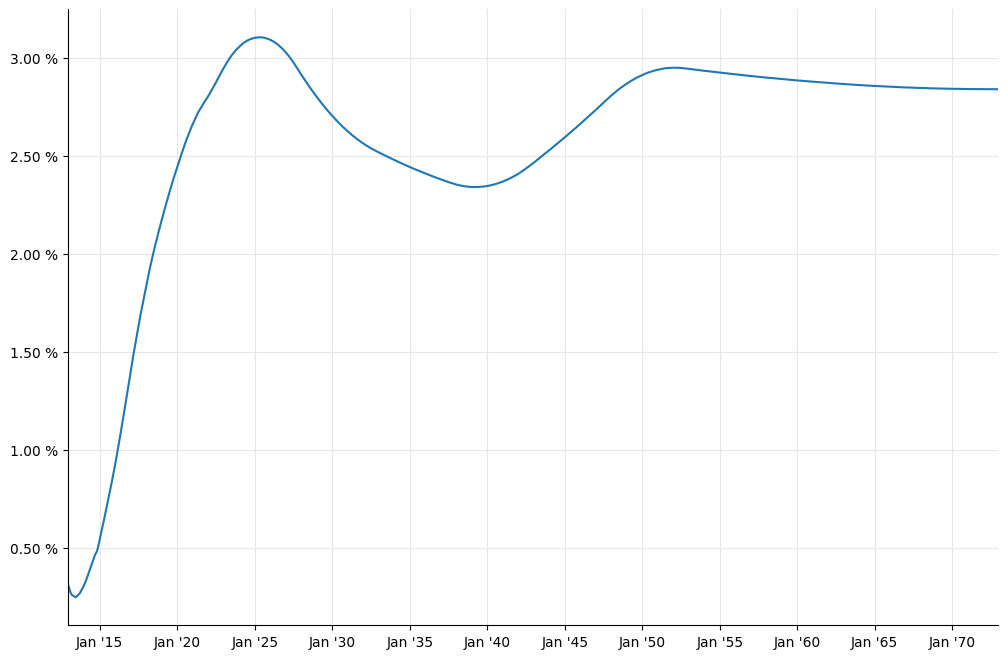

In [17]:
spot = euribor6m_curve.referenceDate()
dates = [ spot+ql.Period(i,ql.Months) for i in range(0, 60*12+1) ]
rates = [ euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d),
                                      ql.Actual360(), ql.Simple).rate()
          for d in dates ]
_, ax = utils.plot()
utils.plot_curve(ax, dates, [(rates, '-')], format_rates=True)

This seems to work, and at the scale of the plot it seems to match figure 32 in the paper; but looking closely at the first part of the curve, you can see a glitch (some kind of dip) in the last part of 2014, when the FRA strip ends.

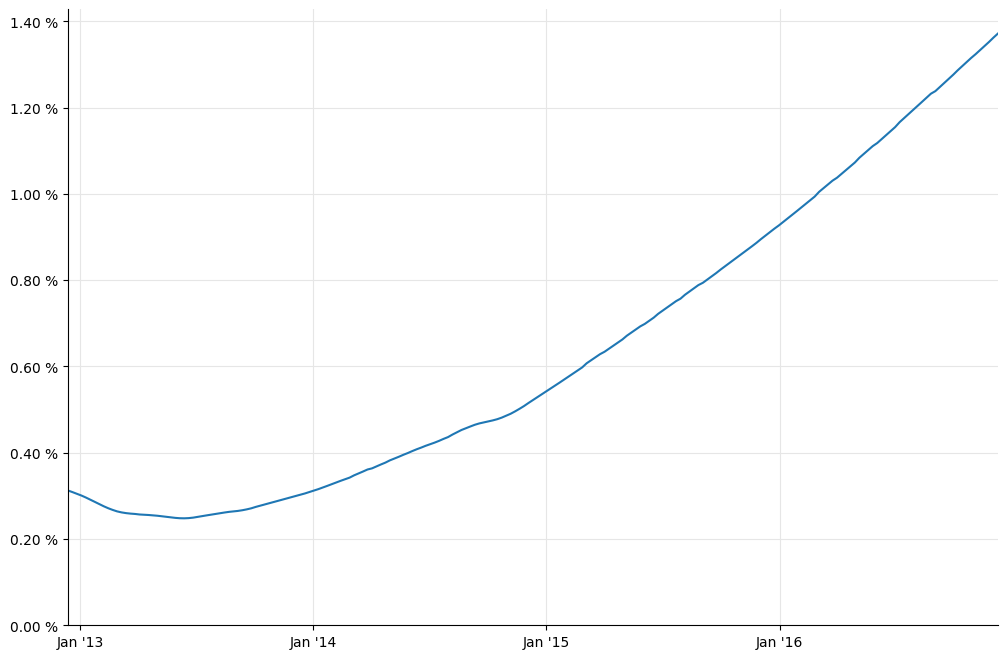

In [18]:
dates = [ spot+ql.Period(i,ql.Weeks) for i in range(0, 52*4+1) ]
rates = [ euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d),
                                      ql.Actual360(), ql.Simple).rate()
          for d in dates ]
_, ax = utils.plot()
utils.plot_curve(ax, dates, [(rates,'-')], ymin=0.0, format_rates=True)

#### Synthetic deposits

In short, the reason is that the short end of the curve (which is required for pricing FRAs; for instance, the 1x7 FRA required the discount factor at 1 month from now) is extrapolated backwards from the first quoted pillar at 6 months and is not quite correct. This leads to oscillations as soon as the curve is out of the tight strip of FRA quotes.

One way to correct this is to add synthetic deposits with short tenors, as explained in section 4.4.2 of the paper. To begin with, let's save the original curve to another variable for later comparison.

In [19]:
euribor6m_curve_0 = euribor6m_curve

As detailed in the paper, one can model the basis between the Euribor market quotes and the corresponding OIS-based rates as a polynomial; that is, following equation 88,

$$
R_{x}(T_1,T_2) \tau(T_1,T_2) = R_{on}(T_1,T_2) \tau(T_1,T_2) + \Delta(T_1,T_2)
$$

In the paper, the expression for $\Delta(T_1,T_2)$ is given by equation 90, that is,

$$
\Delta(T_1, T_2) = \alpha \cdot (T_2-T_1) + \frac{1}{2} \beta \cdot (T_2-T_1)^2
                 + \frac{1}{3} \gamma \cdot (T_2-T_1)^3 + \ldots
$$

However, the above leads to problems when trying to solve for more than one coefficient.  Following [a later formulation](https://speakerdeck.com/nando1970/eonia-jumps-and-proper-euribor-forwarding), I'll express the instantaneous basis instead as 

$$
\delta(t) = \alpha + \beta \cdot t + \gamma \cdot t^2 + \ldots
$$

which leads to

$$
\Delta(T_1, T_2) = \int_{T_1}^{T_2} \delta(t)
                 = \alpha \cdot (T_2-T_1) + \frac{1}{2} \beta \cdot (T_2^2-T_1^2)
                 + \frac{1}{3} \gamma \cdot (T_2^3-T_1^3) + \ldots
$$

Once the basis is known, we can calculate synthetic deposit rates $R(0,T)$ for any maturity $T$.

Depending on how many polynomial coefficients we want to determine, we'll need a corresponding number of market quotes; by replacing their values and those of the OIS rates in equation 88 we can solve for $\alpha$, $\beta$ and any other coefficient.

For a constant polynomial, we'll need one quote to determine $\alpha$; we can use the TOM 6-months deposit that the Euribor curve reprices exactly.

In [20]:
d = ql.TARGET().advance(spot, 1, ql.Days)
F_x = euribor6m_curve_0.forwardRate(d, ql.TARGET().advance(d, 6, ql.Months),
                                    ql.Actual360(), ql.Simple).rate()
F_on = eonia_curve.forwardRate(d, ql.TARGET().advance(d, 6, ql.Months),
                               ql.Actual360(), ql.Simple).rate()
day_counter = euribor6m.dayCounter()
T_x = day_counter.yearFraction(d, ql.TARGET().advance(d, 6, ql.Months))
alpha = (F_x - F_on)
print(alpha)

0.002949286970370156


From the basis, we can instantiate synthetic deposits for a number of maturities below 6 months...

In [21]:
synth_helpers = []
for n, units in [(1, ql.Days), (1, ql.Weeks), (2, ql.Weeks), (3, ql.Weeks),
                 (1, ql.Months), (2, ql.Months), (3, ql.Months),
                 (4, ql.Months), (5, ql.Months)]:
    t = day_counter.yearFraction(spot, ql.TARGET().advance(spot, n, units))
    F_on = eonia_curve.forwardRate(
        spot, ql.TARGET().advance(spot, n, units),
        ql.Actual360(), ql.Simple).rate()
    F = F_on + alpha
    print("{0}: {1}".format(ql.Period(n,units), utils.format_rate(F, 4)))
    synth_helpers.append(
        ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(F)),
                             ql.Period(n, units), 2,
                             ql.TARGET(), ql.Following,
                             False, ql.Actual360()))

1D: 0.3349 %
1W: 0.3649 %
2W: 0.3639 %
3W: 0.3729 %
1M: 0.3689 %
2M: 0.3559 %
3M: 0.3419 %
4M: 0.3272 %
5M: 0.3188 %


...after which we can create a new curve, which seems to have a smaller dip:

In [22]:
euribor6m_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(),
                                               helpers+synth_helpers,
                                               ql.Actual365Fixed())
euribor6m_curve.enableExtrapolation()

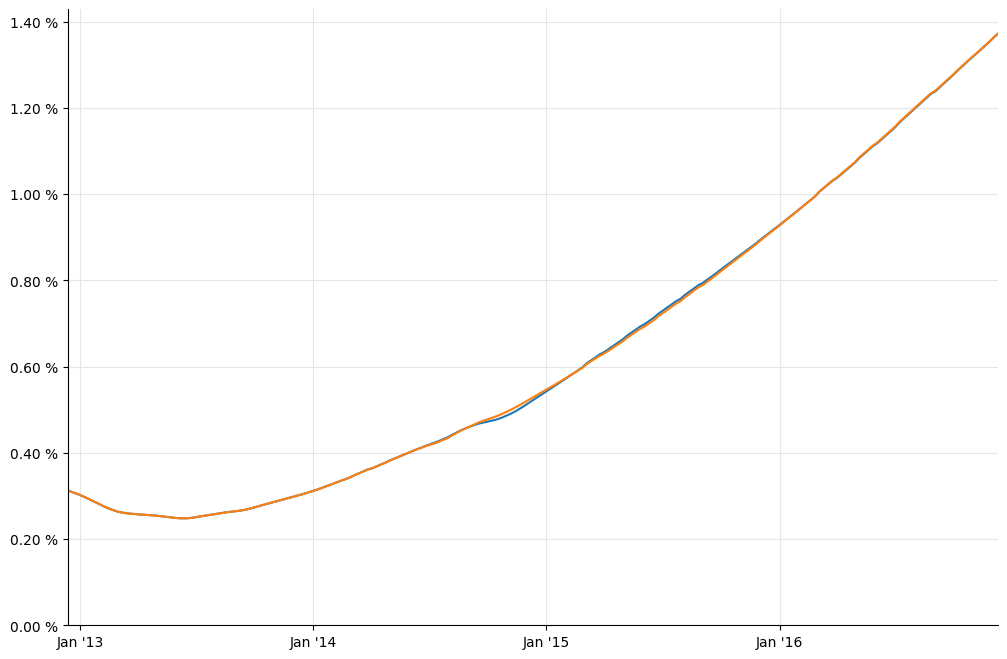

In [23]:
dates = [ spot+ql.Period(i,ql.Weeks) for i in range(0, 52*4+1) ]
rates_0 = [ euribor6m_curve_0.forwardRate(d, euribor6m.maturityDate(d),
                                          ql.Actual360(), ql.Simple).rate()
            for d in dates ]
rates = [ euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d),
                                      ql.Actual360(), ql.Simple).rate()
          for d in dates ]
_, ax = utils.plot()
utils.plot_curve(ax, dates, [(rates_0,'-'), (rates,'-')], ymin=0.0,
                 format_rates=True)

By choosing to sample at different dates, we can zoom into the affected area. The original curve is the dotted line; the new curve is the solid one.

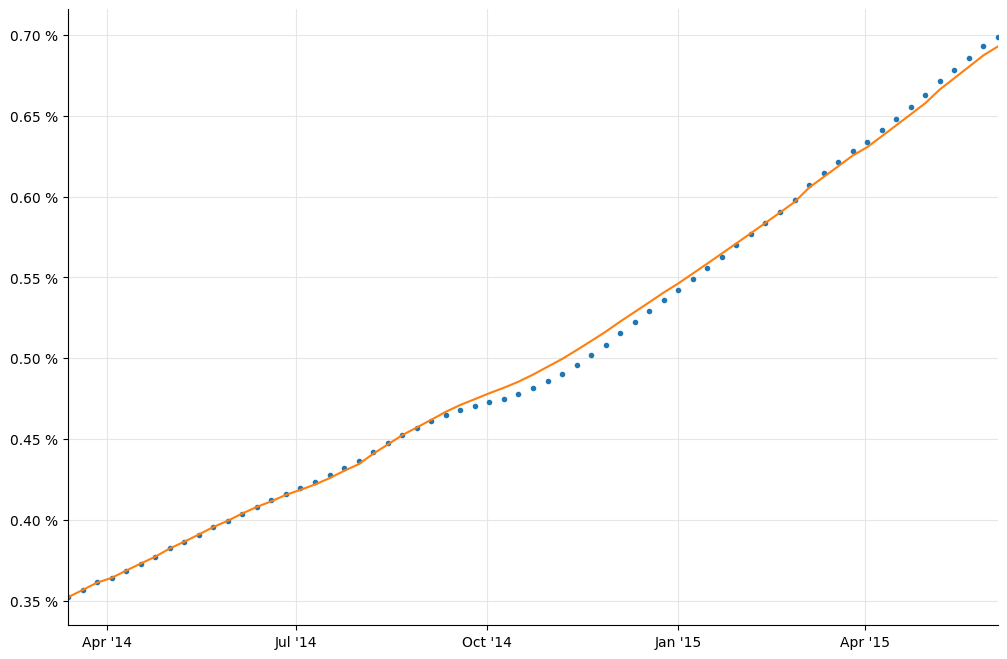

In [24]:
dates = [ spot+ql.Period(i,ql.Weeks) for i in range(65, 130) ]
rates_0 = [ euribor6m_curve_0.forwardRate(d, euribor6m.maturityDate(d),
                                          ql.Actual360(), ql.Simple).rate()
            for d in dates ]
rates = [ euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d),
                                      ql.Actual360(), ql.Simple).rate()
          for d in dates ]
_, ax = utils.plot()
utils.plot_curve(ax, dates, [(rates_0,'.'), (rates,'-')], format_rates=True)

If we wanted to determine more coefficients for the basis, we'd have to select more quotes and solve a linear system. For instance, to determine both $\alpha$ and $\beta$, we can use the TOM 6-months and the 1x7 FRAs:

In [25]:
start = ql.TARGET().advance(spot, 1, ql.Days)
end = ql.TARGET().advance(start, 6, ql.Months)
F_x = euribor6m_curve_0.forwardRate(start, end,
                                    ql.Actual360(), ql.Simple).rate()
F_on = eonia_curve.forwardRate(start, end,
                               ql.Actual360(), ql.Simple).rate()
T_x0 = day_counter.yearFraction(start, end)
Delta0 = F_x - F_on

start = ql.TARGET().advance(spot, 1, ql.Months)
end = ql.TARGET().advance(start, 6, ql.Months)
F_x = euribor6m_curve_0.forwardRate(start, end,
                                    ql.Actual360(), ql.Simple).rate()
F_on = eonia_curve.forwardRate(start, end,
                               ql.Actual360(), ql.Simple).rate()
T_x1 = day_counter.yearFraction(start, end)
Delta1 = F_x - F_on

t1 = day_counter.yearFraction(spot, start)
t2 = day_counter.yearFraction(spot, end)

L = np.array([[T_x0, 0.5*T_x0**2], [T_x1, 0.5*(t2**2-t1**2)]])
b = np.array([Delta0*T_x0, Delta1*T_x1])
alpha, beta = np.linalg.solve(L,b)
print(alpha)
print(beta)

0.0030464085692271255
-0.0003842173141594401


Again, we can create synthetic deposits...

In [26]:
synth_helpers = []
for n, units in [(1, ql.Days),
                 (1, ql.Weeks), (2, ql.Weeks), (3, ql.Weeks),
                 (1, ql.Months), (2, ql.Months), (3, ql.Months),
                 (4, ql.Months), (5, ql.Months)]:
    t = day_counter.yearFraction(spot, ql.TARGET().advance(spot, n, units))
    F_on = eonia_curve.forwardRate(spot, ql.TARGET().advance(spot, n, units),
                                   ql.Actual360(), ql.Simple).rate()
    F = F_on + alpha + 0.5*beta*t
    print("{0}: {1}".format(ql.Period(n,units), utils.format_rate(F, 4)))
    synth_helpers.append(
        ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(F)),
                             ql.Period(n, units), 2,
                             ql.TARGET(), ql.Following,
                             False, ql.Actual360()))

1D: 0.3446 %
1W: 0.3743 %
2W: 0.3729 %
3W: 0.3815 %
1M: 0.3769 %
2M: 0.3623 %
3M: 0.3468 %
4M: 0.3304 %
5M: 0.3204 %


...and build a new curve. I'll leave it to you to decide whether this is an improvement over the degree-1 polynomial basis.

In [27]:
euribor6m_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(),
                                               helpers+synth_helpers,
                                               ql.Actual365Fixed())
euribor6m_curve.enableExtrapolation()

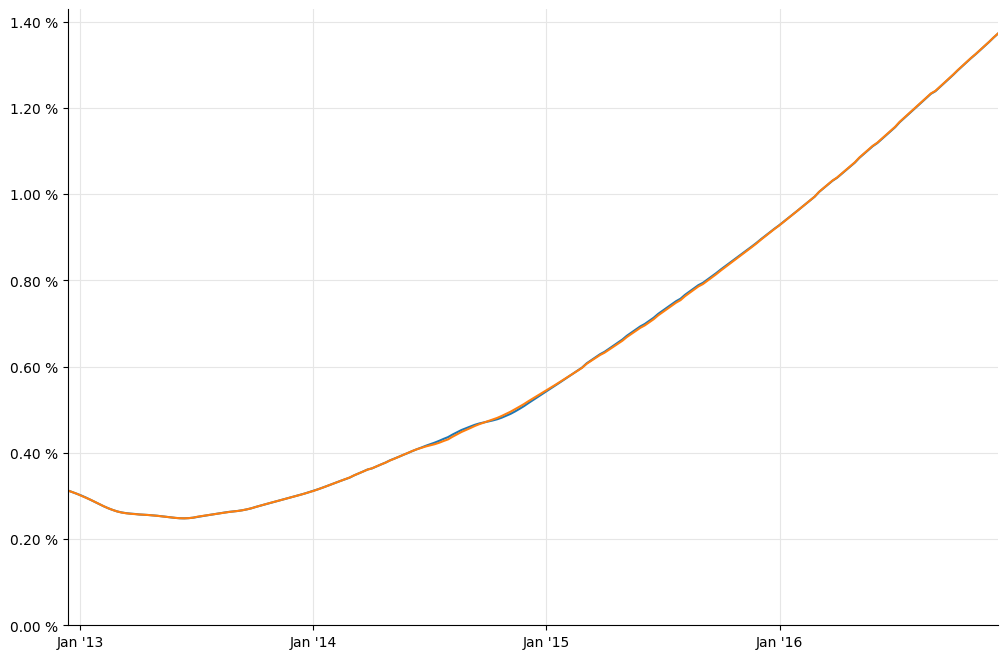

In [28]:
dates = [ spot+ql.Period(i,ql.Weeks) for i in range(0, 52*4+1) ]
rates_0 = [ euribor6m_curve_0.forwardRate(d, euribor6m.maturityDate(d),
                                          ql.Actual360(), ql.Simple).rate()
            for d in dates ]
rates = [ euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d),
                                      ql.Actual360(), ql.Simple).rate()
          for d in dates ]
_, ax = utils.plot()
utils.plot_curve(ax, dates, [(rates_0,'-'), (rates,'-')], ymin=0.0,
                 format_rates=True)

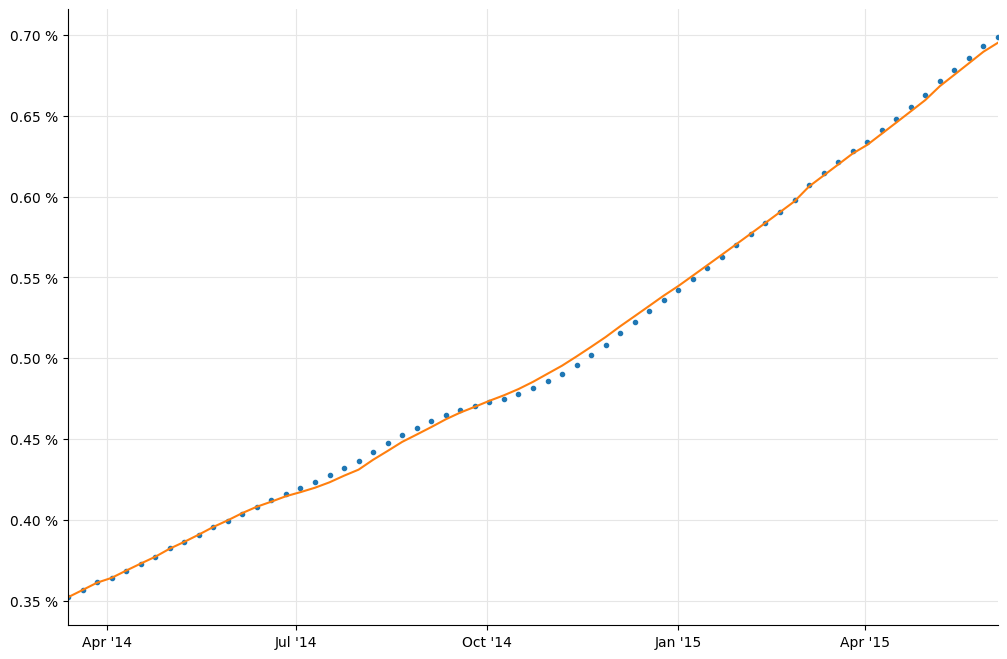

In [29]:
dates = [ spot+ql.Period(i,ql.Weeks) for i in range(65, 130) ]
rates_0 = [ euribor6m_curve_0.forwardRate(d, euribor6m.maturityDate(d),
                                          ql.Actual360(), ql.Simple).rate()
            for d in dates ]
rates = [ euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d),
                                      ql.Actual360(), ql.Simple).rate()
          for d in dates ]
_, ax = utils.plot()
utils.plot_curve(ax, dates, [(rates_0,'.'), (rates,'-')], format_rates=True)

One thing to note: the values I'm getting for the synthetic deposits are not the same as those reported by the paper in figure 17.  I still haven't found the reason for the discrepancy.

As for figure 32 in the paper, here's how we can reproduce it:

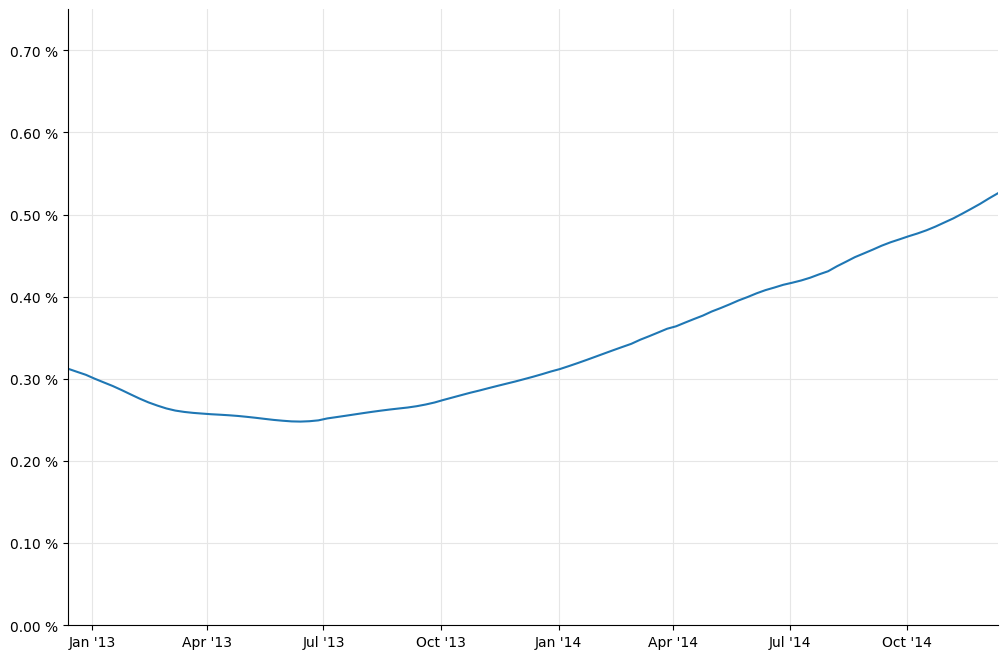

In [30]:
spot = euribor6m_curve.referenceDate()
dates = [ spot+ql.Period(i,ql.Weeks) for i in range(0, 2*52+1) ]
rates = [ euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d),
                                      ql.Actual360(), ql.Simple).rate()
          for d in dates ]
_, ax = utils.plot()
utils.plot_curve(ax, dates, [(rates, '-')], ymin=0.0, ymax=0.0075,
                 format_rates=True)

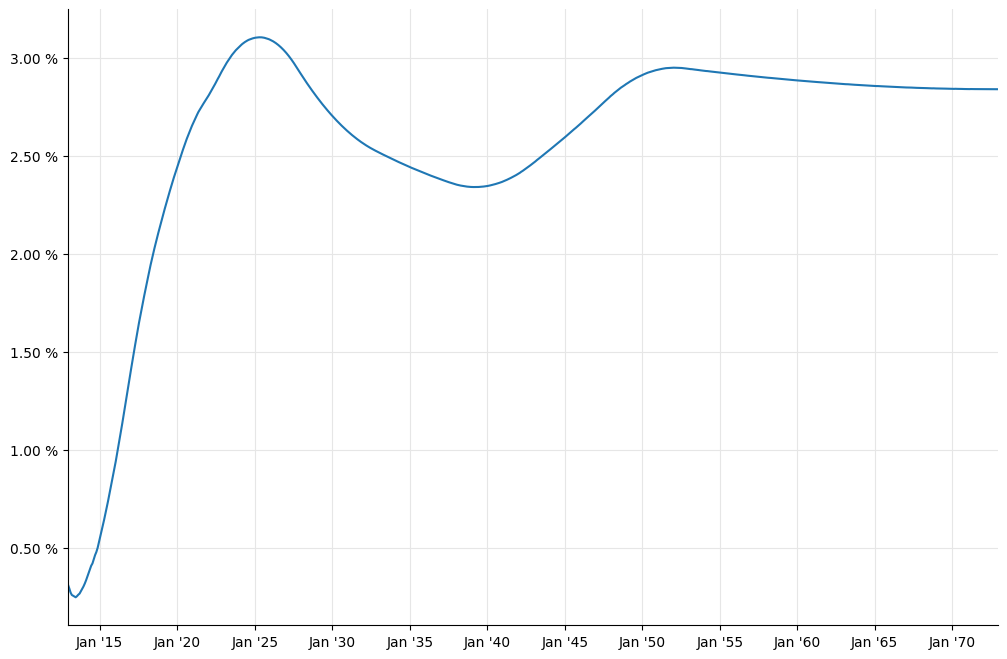

In [31]:
spot = euribor6m_curve.referenceDate()
dates = [ spot+ql.Period(i,ql.Months) for i in range(0, 60*12+1) ]
rates = [ euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d),
                                      ql.Actual360(), ql.Simple).rate()
          for d in dates ]
_, ax = utils.plot()
utils.plot_curve(ax, dates, [(rates, '-')], format_rates=True)

#### 12-months Euribor

For the 12-months curve, we'll start with the quoted 12-months deposit and 12x24 FRA (see figures 4 and 5).

In [32]:
euribor12m = ql.Euribor1Y()
helpers = [
    ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(0.54/100)),
                         ql.Period(12,ql.Months), 2,
                         ql.TARGET(), ql.Following, False, ql.Actual360())
]
helpers += [
    ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(0.5070/100)),
                     12, euribor12m)
]

Unfortunately, there are no quoted swap rates against 12-months Euribor.  However, the market quotes 6- vs 12-months basis swaps; and more importantly, it quotes them as a portfolio of two IRS, payer and receiver, both accruing annual fixed coupons against Euribor 6M and 12M, respectively. The spread between the two fixed legs is quoted so that it sets the NPV of the portfolio at zero.

Given that the market also quotes the fair fixed rate for one of the two swaps, i.e., the one paying a fixed rate against Euribor 6M, it's straightforward to see that the fair fixed rate for the swap against Euribor 12M can be obtained by just adding the 6M rate to the basis spread: that is, if the NPV of a swap $S_1$ paying $K$ against Euribor 6M is 0, and if the NPV of the portfolio of $S_1$ minus another swap $S_2$ paying $K+S$ against Euribor 12M is also 0, then the NPV of $S_2$ must be 0 as well.

This gives us quoted swap rates against Euribor 12M up to 30 years, which is the longest quoted maturity for basis swaps. The data are from figures 9 and 15.

In [33]:
helpers += [
    ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote((rate+basis)/100)),
                      ql.Period(tenor, ql.Years), ql.TARGET(),
                      ql.Annual, ql.Unadjusted,
                      ql.Thirty360(ql.Thirty360.BondBasis),
                      euribor12m, ql.QuoteHandle(), ql.Period(0, ql.Days),
                      discount_curve)
    for rate, basis, tenor in [(0.424, 0.179, 3), (0.576, 0.164, 4),
                               (0.762, 0.151, 5), (0.954, 0.139, 6),
                               (1.135, 0.130, 7), (1.303, 0.123, 8),
                               (1.452, 0.118, 9), (1.584, 0.113, 10),
                               (1.809, 0.106, 12), (2.037, 0.093, 15),
                               (2.187, 0.080, 20), (2.234, 0.072, 25),
                               (2.256, 0.066, 30)] ]

Again, we'll be using synthetic helpers to improve the shape of the short end of the curve.  The same procedure we used for the Euribor 6M curve lets us create deposits with a number of maturities below 1 year; I'll skip the calculation and just create helpers with the the resulting rates as reported by the paper.

In [34]:
synth_helpers = [
    ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100)),
                         ql.Period(*tenor), 2,
                         ql.TARGET(), ql.Following, False, ql.Actual360())
    for rate, tenor in [(0.6537, (1,ql.Months)), (0.6187, (3,ql.Months)),
                        (0.5772, (6,ql.Months)), (0.5563, (9,ql.Months))] ]

It is also possible to build synthetic FRAs: their construction is explained in the paper. I'll leave it to a later version of this chapter; for the time being, I'll just add the finished helpers.

In [35]:
synth_helpers += [
    ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100)),
                     months_to_start, euribor12m)
    for rate, months_to_start in [(0.4974, 3), (0.4783, 6), (0.4822, 9),
                                  (0.5481, 15), (0.6025, 18)] ]

Finally, we can extend the long end of the curve by creating synthetic swaps with maturities above 30 years.  To calculate their rates, we add the swap rates against Euribor 6M (quoted up to 60 years) to the last quoted basis spread.

In [36]:
last_basis = 0.066
synth_helpers += [
    ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote((rate+last_basis)/100)),
                      ql.Period(tenor, ql.Years), ql.TARGET(),
                      ql.Annual, ql.Unadjusted,
                      ql.Thirty360(ql.Thirty360.BondBasis),
                      euribor12m, ql.QuoteHandle(), ql.Period(0, ql.Days),
                      discount_curve)
    for rate, tenor in [(2.295, 35), (2.348, 40),
                        (2.421, 50), (2.463, 60)] ]

Bootstrapping over the whole set of real and synthetic quotes gives us our final Euribor 12M curve:

In [37]:
euribor12m_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(),
                                                helpers+synth_helpers,
                                                ql.Actual365Fixed())
euribor12m_curve.enableExtrapolation()

For comparison, we can build another one excluding the synthetic helpers.

In [38]:
euribor12m_curve_0 = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(), helpers,
                                                  ql.Actual365Fixed())
euribor12m_curve_0.enableExtrapolation()

The two curves are plotted together in the two following graphs, which also reproduce figure 34 in the paper.  The solid line corresponds to the complete curve, and the dashed line to the curve without the synthetic helpers.  The differences are obvious, both in the short and in the long end.

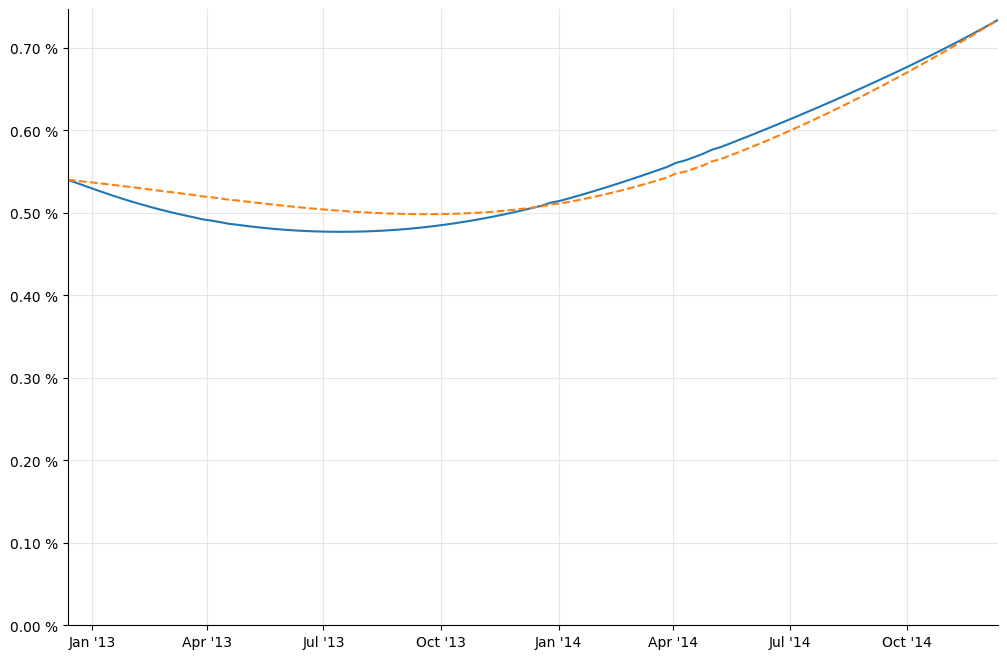

In [39]:
spot = euribor12m_curve.referenceDate()
dates = [ spot+ql.Period(i,ql.Weeks) for i in range(0, 2*52+1) ]
rates_0 = [ euribor12m_curve_0.forwardRate(d, euribor12m.maturityDate(d),
                                           ql.Actual360(), ql.Simple).rate()
            for d in dates ]
rates = [ euribor12m_curve.forwardRate(d, euribor12m.maturityDate(d),
                                       ql.Actual360(), ql.Simple).rate()
          for d in dates ]
_, ax = utils.plot()
utils.plot_curve(ax, dates, [(rates, '-'),(rates_0, '--')], ymin=0.0,
                 format_rates=True)

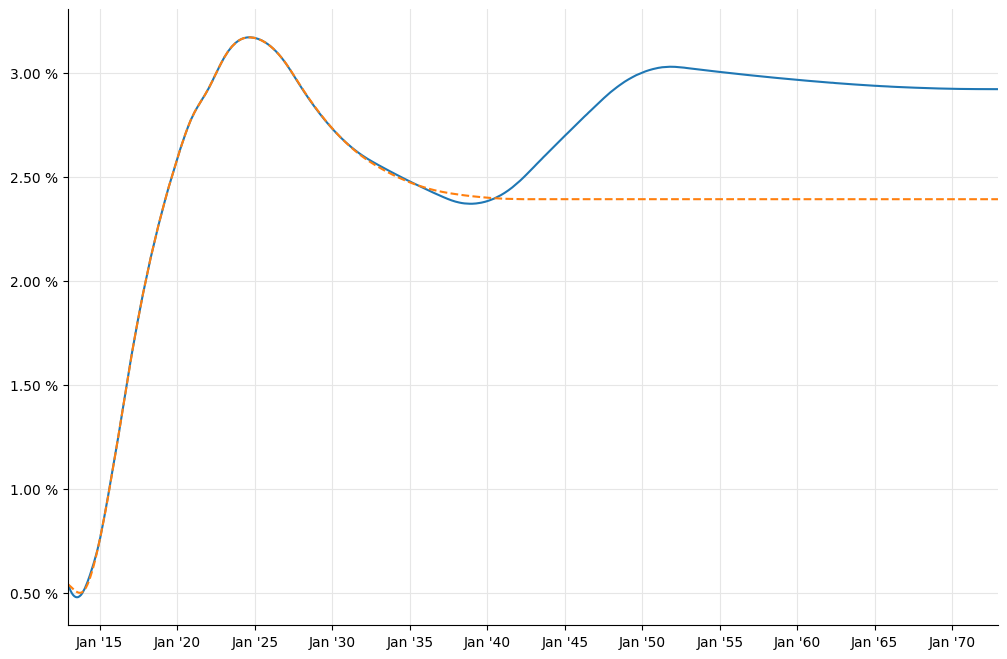

In [40]:
dates = [ spot+ql.Period(i,ql.Months) for i in range(0, 60*12+1) ]
rates_0 = [ euribor12m_curve_0.forwardRate(d, euribor12m.maturityDate(d),
                                           ql.Actual360(), ql.Simple).rate()
            for d in dates ]
rates = [ euribor12m_curve.forwardRate(d, euribor12m.maturityDate(d),
                                       ql.Actual360(), ql.Simple).rate()
          for d in dates ]
_, ax = utils.plot()
utils.plot_curve(ax, dates, [(rates, '-'), (rates_0, '--')],
                 format_rates=True)

#### 3-months Euribor

For the 3-months Euribor, we can use a strip of very liquid futures after the 3-months deposit; their rates are listed in figures 7 and 4, respectively.

In [41]:
euribor3m = ql.Euribor3M()
helpers = [ ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(0.179/100)),
                                 ql.Period(3,ql.Months), 3,
                                 ql.TARGET(), ql.Following,
                                 False, ql.Actual360()) ]
helpers += [
    ql.FuturesRateHelper(ql.QuoteHandle(ql.SimpleQuote(100-rate)),
                         start_date, euribor3m, ql.QuoteHandle())
    for rate, start_date in [(0.1775, ql.Date(19, ql.December, 2012)),
                             (0.1274, ql.Date(20, ql.March, 2013)),
                             (0.1222, ql.Date(19, ql.June, 2013)),
                             (0.1269, ql.Date(18, ql.September, 2013)),
                             (0.1565, ql.Date(18, ql.December, 2013)),
                             (0.1961, ql.Date(19, ql.March, 2014)),
                             (0.2556, ql.Date(18, ql.June, 2014)),
                             (0.3101, ql.Date(17, ql.September, 2014))] ]

For the swaps, we combine quotes for the swaps against 6-months Euribor with quotes for the 3-months against 6-months basis swap, like we did for the 12-months curve; basis swap quotes for this tenor are available up to 50 years, as shown in figure 15. In this case, though, the fixed rate against Euribor 3M is lower than the one against Euribor 6M; therefore, the basis must be subtracted from the quoted rate:

In [42]:
helpers += [
    ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote((rate-basis)/100)),
                      ql.Period(tenor, ql.Years), ql.TARGET(),
                      ql.Annual, ql.Unadjusted,
                      ql.Thirty360(ql.Thirty360.BondBasis),
                      euribor3m, ql.QuoteHandle(), ql.Period(0, ql.Days),
                      discount_curve)
    for rate, basis, tenor in [(0.424, 0.1395, 3), (0.576, 0.1390, 4),
                               (0.762, 0.1395, 5), (0.954, 0.1375, 6),
                               (1.135, 0.1350, 7), (1.303, 0.1320, 8),
                               (1.452, 0.1285, 9), (1.584, 0.1250, 10),
                               (1.809, 0.1170, 12), (2.037, 0.1045, 15),
                               (2.187, 0.0885, 20), (2.234, 0.0780, 25),
                               (2.256, 0.0700, 30), (2.348, 0.0600, 40),
                               (2.421, 0.0540, 50)] ]

Again, synthetic deposit rates can be calculated and added for short maturities...

In [43]:
synth_helpers = [
    ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100)),
                         ql.Period(*tenor), 2,
                         ql.TARGET(), ql.Following, False, ql.Actual360())
    for rate, tenor in [(0.1865, (2,ql.Weeks)), (0.1969, (3,ql.Weeks)),
                        (0.1951, (1,ql.Months)), (0.1874, (2,ql.Months))] ]

...and again, we can add a few synthetic swaps where quotes for the 3-months versus 6-months Euribor are not available. We can calculate a quote for the 35-years basis swap by interpolating between the 30- and 40-years quotes, and one for the 60-years swap by extrapolating the 50-years quote flatly, like we did for the 12-months Euribor. Note that in this case, the authors of the paper choose instead to extrapolate the previous quotes linearly; anyway, this gives a difference of less than half a basis point.

In [44]:
synth_helpers += [
    ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote((rate-basis)/100)),
                      ql.Period(tenor, ql.Years), ql.TARGET(),
                      ql.Annual, ql.Unadjusted,
                      ql.Thirty360(ql.Thirty360.BondBasis),
                      euribor3m, ql.QuoteHandle(), ql.Period(0, ql.Days),
                      discount_curve)
    for rate, basis, tenor in [(2.295, 0.0650, 35), (2.463, 0.0540, 60)] ]

#### Turn of year

This is not the end of the story, though, since one of the futures we used turns out to be out of line with respect to the others in the strip.

In [45]:
futures = [(0.1775, ql.Date(19, ql.December, 2012)),
           (0.1274, ql.Date(20, ql.March, 2013)),
           (0.1222, ql.Date(19, ql.June, 2013)),
           (0.1269, ql.Date(18, ql.September, 2013)),
           (0.1565, ql.Date(18, ql.December, 2013)),
           (0.1961, ql.Date(19, ql.March, 2014)),
           (0.2556, ql.Date(18, ql.June, 2014)),
           (0.3101, ql.Date(17, ql.September, 2014))]

Not surprisingly, it's the one that spans the end of the year and thus includes the corresponding jump; that is, the one at index 4 in the list, starting on December 18th. This can be seen clearly enough by fitting a spline between the other futures and plotting the quoted value against the curve:

In [46]:
spot = euribor6m_curve.referenceDate()
day_counter = euribor3m.dayCounter()
quotes, times = zip(*[(q, day_counter.yearFraction(spot, d))
                      for q,d in futures])
f = ql.MonotonicCubicNaturalSpline(times[:4]+times[5:],
                                   quotes[:4]+quotes[5:])

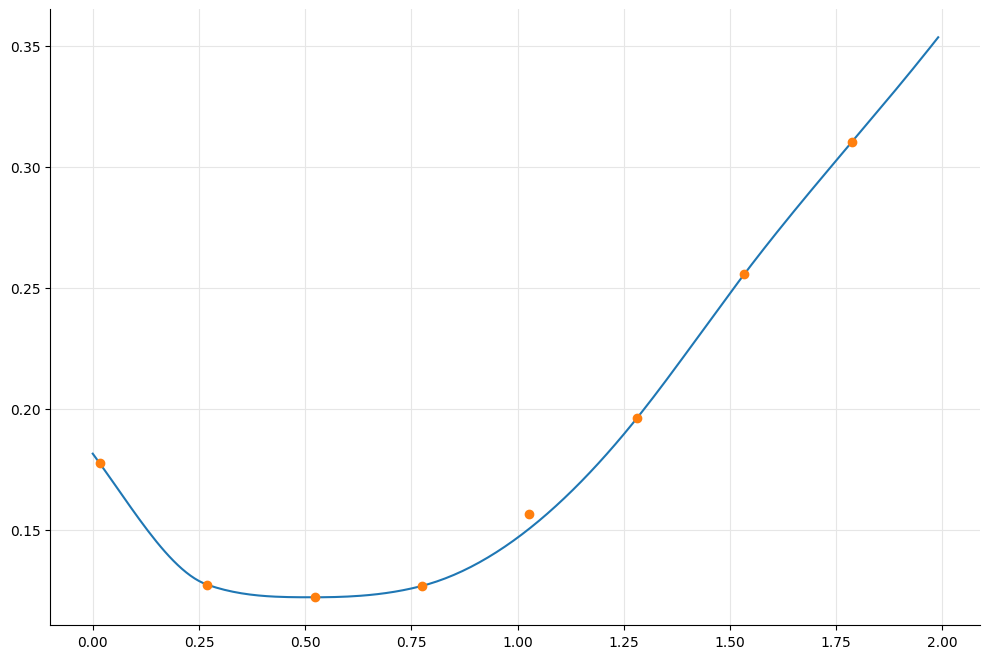

In [47]:
_, ax = utils.plot()
ts, fs = zip(*[(t,f(t, True)) for t in np.arange(0.0, 2.0, 0.01)])
ax.plot(ts,fs)
_ = ax.plot(times,quotes,'o')

We can also ask the interpolation for the estimated value and compare it with the real one:

In [48]:
print(utils.format_rate(quotes[4]))
print(utils.format_rate(f(times[4])))

15.65 %
15.06 %


To account for the jump, we can estimate the corresponding discount factor $e^{-J*\tau}$ (where both $J$ and $\tau$ are calculated with respect to the tenor of the futures) and add it to the curve.

In [49]:
J = (quotes[4] - f(times[4]))/100
tau = day_counter.yearFraction(ql.Date(18,ql.December,2013),
                               ql.Date(18,ql.March,2014))
print(utils.format_rate(J))
print(tau)

0.01 %
0.25


In [50]:
jumps = [ql.QuoteHandle(ql.SimpleQuote(math.exp(-J*tau)))]
jump_dates = [ql.Date(31,ql.December,2013)]
euribor3m_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(),
                                               helpers+synth_helpers,
                                               ql.Actual365Fixed(),
                                               jumps, jump_dates)
euribor3m_curve.enableExtrapolation()

We can now reproduce figure 30 in the paper. The end-of-year jump can be seen clearly in the first plot.

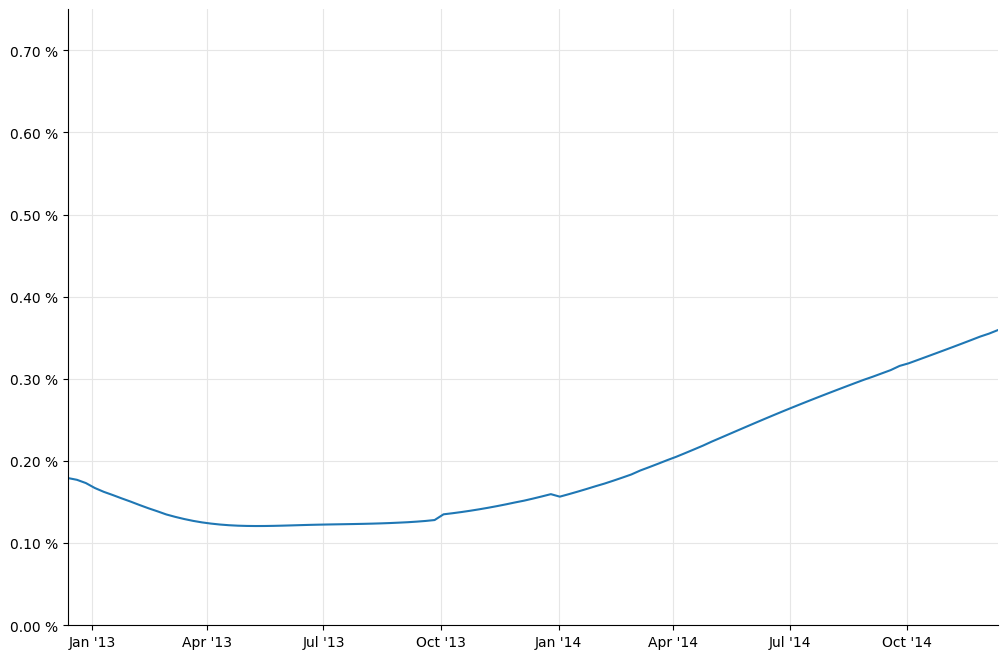

In [51]:
spot = euribor3m_curve.referenceDate()
dates = [ spot+ql.Period(i,ql.Weeks) for i in range(0, 2*52+1) ]
rates = [ euribor3m_curve.forwardRate(d, euribor3m.maturityDate(d),
                                      ql.Actual360(), ql.Simple).rate()
          for d in dates ]
_, ax = utils.plot()
utils.plot_curve(ax, dates, [(rates, '-')], ymin=0.0, ymax=0.0075,
                 format_rates=True)

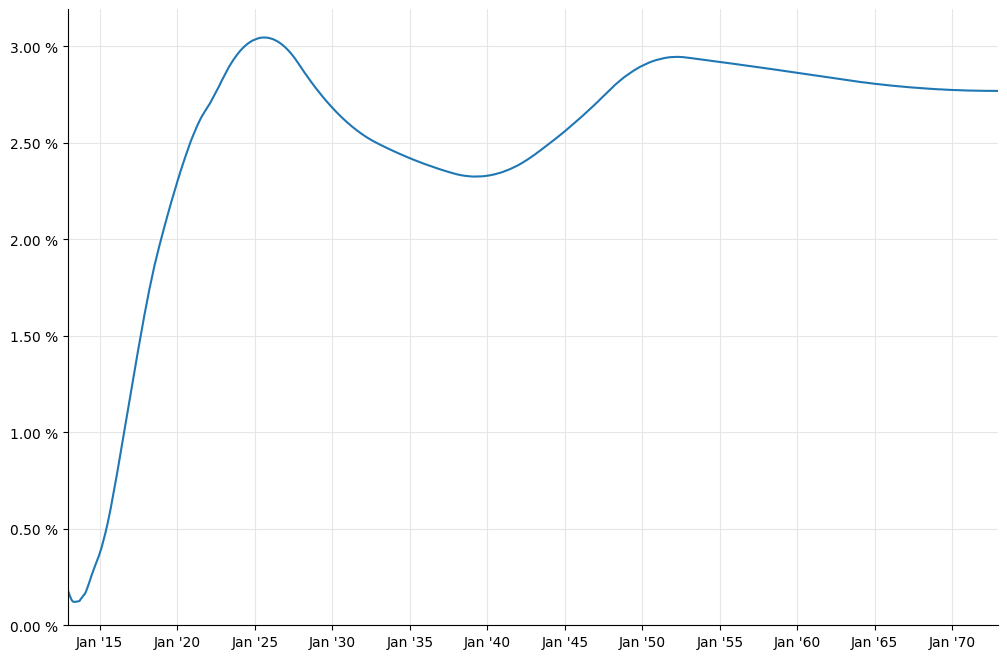

In [52]:
dates = [ spot+ql.Period(i,ql.Months) for i in range(0, 60*12+1) ]
rates = [ euribor3m_curve.forwardRate(d, euribor3m.maturityDate(d),
                                      ql.Actual360(), ql.Simple).rate()
          for d in dates ]
_, ax = utils.plot()
utils.plot_curve(ax, dates, [(rates, '-')], ymin=0.0, format_rates=True)

#### 1-month Euribor

Last, let's bootstrap the 1-month Euribor curve. Quoted instruments based on this tenor include the 1-month deposit and interest-rate swaps paying a monthly fixed rate against 1-month Euribor with maturities up to 1 year; their rates are listed in figures 4 and 11.

In [53]:
euribor1m = ql.Euribor1M()
helpers = [
    ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(0.110/100)),
                         ql.Period(1,ql.Months), 2,
                         ql.TARGET(), ql.Following, False, ql.Actual360())
]
helpers += [
    ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100)),
                      ql.Period(tenor, ql.Months), ql.TARGET(),
                      ql.Monthly, ql.Unadjusted,
                      ql.Thirty360(ql.Thirty360.BondBasis),
                      euribor1m, ql.QuoteHandle(), ql.Period(0, ql.Days),
                      discount_curve)
    for rate, tenor in [(0.106, 2), (0.096, 3), (0.085, 4), (0.079, 5),
                        (0.075, 6), (0.071, 7), (0.069, 8), (0.066, 9),
                        (0.065, 10), (0.064, 11), (0.063, 12)] ]

For longer maturities, we can combine the swaps against 6-months Euribor with the 1-month vs 6-months basis swaps shown in figure 15.

In [54]:
helpers += [
    ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote((rate-basis)/100)),
                      ql.Period(tenor, ql.Years), ql.TARGET(),
                      ql.Annual, ql.Unadjusted,
                      ql.Thirty360(ql.Thirty360.BondBasis),
                      euribor1m, ql.QuoteHandle(), ql.Period(0, ql.Days),
                      discount_curve)
    for rate, basis, tenor in [(0.324, 0.226, 2), (0.424, 0.238, 3),
                               (0.576, 0.246, 4), (0.762, 0.250, 5),
                               (0.954, 0.250, 6), (1.135, 0.248, 7),
                               (1.303, 0.245, 8), (1.452, 0.241, 9),
                               (1.584, 0.237, 10), (1.703, 0.233, 11),
                               (1.809, 0.228, 12), (2.037, 0.211, 15),
                               (2.187, 0.189, 20), (2.234, 0.175, 25),
                               (2.256, 0.163, 30)] ]

As before, we can use synthetic deposits for maturities below the 1-month tenor...

In [55]:
synth_helpers = [
    ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100)),
                         ql.Period(*tenor), 2,
                         ql.TARGET(), ql.Following, False, ql.Actual360())
    for rate, tenor in [(0.0661, (1,ql.Days)), (0.098, (1,ql.Weeks)),
                        (0.0993, (2,ql.Weeks)), (0.1105, (3,ql.Weeks))] ]

...and we'll extend the 30-years basis spread flatly to combine it with longer-maturity swaps against 6-months Euribor.

In [56]:
last_basis = 0.163
synth_helpers += [
    ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote((rate-last_basis)/100)),
                      ql.Period(tenor, ql.Years), ql.TARGET(),
                      ql.Annual, ql.Unadjusted,
                      ql.Thirty360(ql.Thirty360.BondBasis),
                      euribor1m, ql.QuoteHandle(), ql.Period(0, ql.Days),
                      discount_curve)
    for rate, tenor in [(2.295, 35), (2.348, 40),
                        (2.421, 50), (2.463, 60)] ]

This curve, too, shows a jump at the end of the year.  The paper claims that it can be determined and corrected by interpolating the quoted swaps with maturities from 1 to 12 months, but I haven't reproduced the calculation yet. For the time being, I'll just use the value reported in the paper and calculate the corresponding discount factor.

In [57]:
J = 0.0016
t_j = euribor1m.dayCounter().yearFraction(ql.Date(31,ql.December,2012),
                                          ql.Date(2,ql.January,2013))
B = 1.0/(1.0+J*t_j)
jumps = [ql.QuoteHandle(ql.SimpleQuote(B))]
jump_dates = [ql.Date(31,ql.December,2013)]

In [58]:
euribor1m_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(),
                                               helpers+synth_helpers,
                                               ql.Actual365Fixed(),
                                               jumps, jump_dates)
euribor1m_curve.enableExtrapolation()

This last curve gives us figure 28 in the paper, down to the oscillations during the first year.

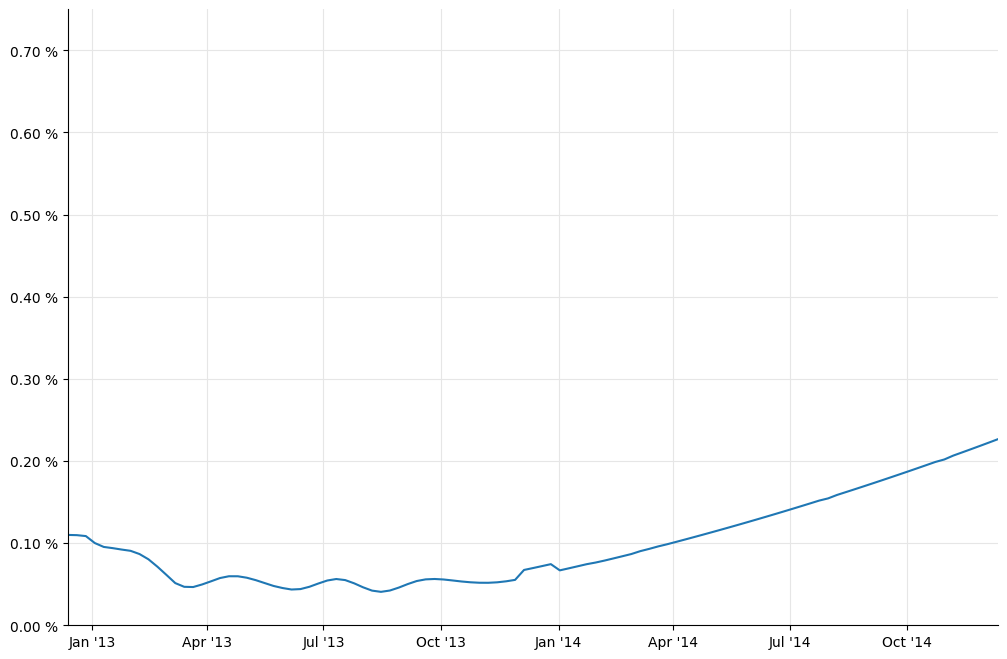

In [59]:
spot = euribor1m_curve.referenceDate()
dates = [ spot+ql.Period(i,ql.Weeks) for i in range(0, 2*52+1) ]
rates = [ euribor1m_curve.forwardRate(d, euribor1m.maturityDate(d),
                                      ql.Actual360(), ql.Simple).rate()
          for d in dates ]
_, ax = utils.plot()
utils.plot_curve(ax, dates, [(rates, '-')], ymin=0.0, ymax=0.0075,
                 format_rates=True)

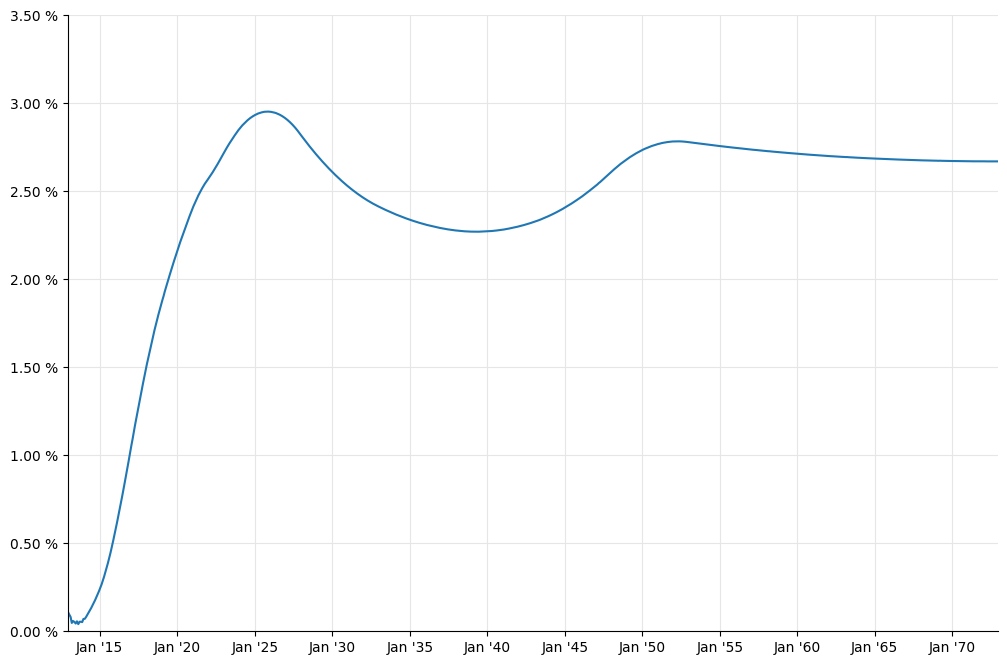

In [60]:
dates = [ spot+ql.Period(i,ql.Months) for i in range(0, 60*12+1) ]
rates = [ euribor1m_curve.forwardRate(d, euribor1m.maturityDate(d),
                                      ql.Actual360(), ql.Simple).rate()
          for d in dates ]
_, ax = utils.plot()
utils.plot_curve(ax, dates, [(rates, '-')], ymin=0.0, ymax=0.035,
                 format_rates=True)

#### Basis curves

Finally, like the authors of the paper, we summarize the results by calculating the difference between the FRA rates calculated on the corresponding Euribor curve and those calculated on the ON curve. This lets us reproduce the top panel of figure 35.

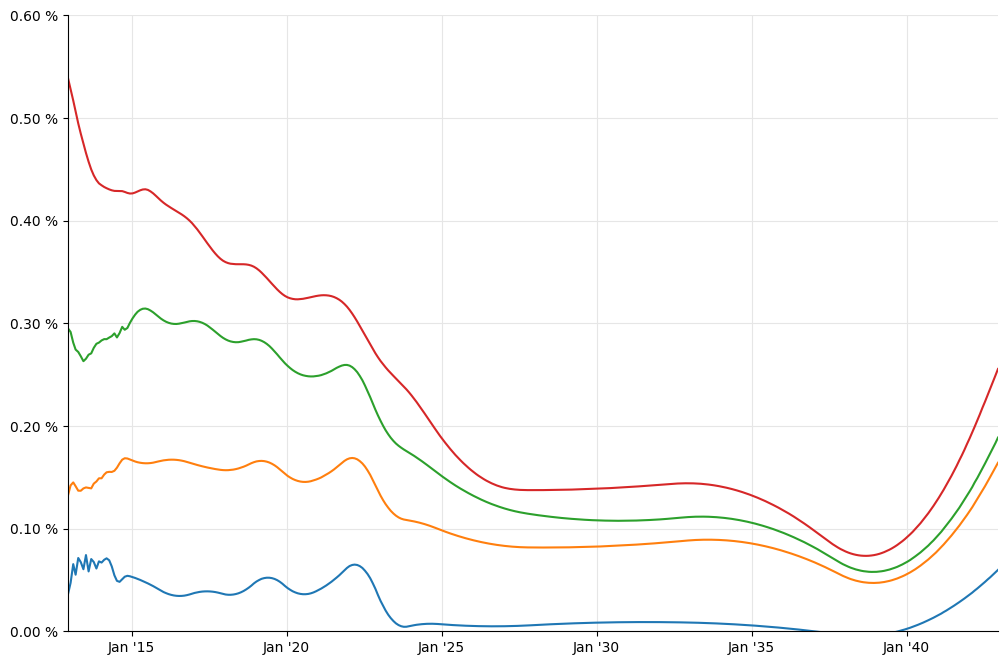

In [61]:
dates = [ spot+ql.Period(i,ql.Months) for i in range(0, 12*30+1) ]

def basis(curve, tenor):
    results = []
    for d in dates:
        d2 = ql.TARGET().advance(d, ql.Period(*tenor), ql.ModifiedFollowing)
        FRA1 = curve.forwardRate(d, d2, ql.Actual360(), ql.Simple).rate()
        FRA2 = eonia_curve.forwardRate(d, d2, ql.Actual360(), ql.Simple).rate()
        results.append(FRA1-FRA2)
    return results

basis_1m = basis(euribor1m_curve, (1,ql.Months))
basis_3m = basis(euribor3m_curve, (3,ql.Months))
basis_6m = basis(euribor6m_curve, (6,ql.Months))
basis_12m = basis(euribor12m_curve, (12,ql.Months))

_, ax = utils.plot()
utils.plot_curve(ax, dates, [(basis_1m, '-'), (basis_3m, '-'),
                             (basis_6m, '-'), (basis_12m, '-')],
                 ymin=0, ymax=0.006, format_rates=True)